# spatstat-interface

- GitHub https://github.com/For-a-few-DPPs-more/spatstat-interface
- PyPI https://pypi.org/project/spatstat-interface

## Run the notebook remotely

If you're running the notebook remotely, e.g., on Google Colab, `spatstat-interface` and its dependencies need to be installed.

To do this, uncomment and run one of the command below that suits best your needs.

In [1]:
# You want to use the latest version published on PyPI there
# !pip install spatstat-interface
# You want to use the latest version of the source code available on GitHub
# !pip install git+https://github.com/For-a-few-DPPs-more/spatstat-interface.git

## Run the notebook locally

If you're running the notebook on your local machine, please 

- follow the instructions provided in the [`notebooks/README.md`](https://github.com/For-a-few-DPPs-more/spatstat-interface/blob/main/notebooks/) file, 
- or fallback on the instructions given in [Run the notebook remotely](#run-the-notebook-remotely).

---

If you're working in development mode run the following cell to reflect changes made to the source files during the development phase.

In [2]:
%load_ext autoreload
%autoreload 2

# Spatstat playground

Let's take Determinantal Point Processes (DPPs) as a running example to play with the [`spatstat`](https://spatstat.org/) (Spatial Statistics) R package from Python!

More specifically, we'll perform both sampling and inference on DPPs using `spatstat`.

To do this, one can use the Python package [`rpy2`](https://rpy2.github.io/doc/v3.4.x/html/overview.html#installation) to ensure the interoperability with [`R`](https://www.r-project.org/).
In other words, `rpy2` allows us to call `R` from `Python`.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format='retina'

import rpy2.robjects as robjects
# Activate automatic conversion of numpy floats and arrays to corresponding R objects
from rpy2.robjects import numpy2ri
numpy2ri.activate() #numpy2ri.deactivate()

---

`spatstat` has been split into multiple subpackages and extensions, see [`spatstat` GitHub repo](https://github.com/spatstat/spatstat).

In this notebook will make use of
- [spatstat.core](https://www.rdocumentation.org/packages/spatstat.core/versions/2.2-0)
- [spatstat.geom](https://www.rdocumentation.org/packages/spatstat.core/versions/2.2-0)

---

Beware that R and Python have different syntax, hence few adaptations must be made when calling functions.
See the "Documentation" section of the [`./README.md`](https://github.com/For-a-few-DPPs-more/spatstat-interface/blob/main/README.md#Documentation) file.

In [4]:
from spatstat_interface.utils import to_pandas_data_frame
from spatstat_interface.interface import SpatstatInterface

spatstat = SpatstatInterface()  
spatstat.import_package("core", "geom", update=False)
# On Google Colab use update=True
# update=True to install if not already installed and make sure the latest versions are used
spatstat.core.__version__ # >= 2.3-0

'2.4-2'

## DPPs with stationary isotropic kernels

### Gaussian kernel

$K(x, y) = \rho \exp(−\|\frac{x - y}{\alpha}\|^2)$

$\rho_{\max} = \left(\sqrt{\pi} \alpha\right)^{-d}$

In [5]:
rho = 100
alpha = 0.05
d = 2
rho_max = (np.sqrt(np.pi) * alpha)**(-d)
assert rho <= rho_max

# spatstat.core.dppGauss(lambda=, alpha=, d=)
# However lambda is a reserved Python keyword
# Let's circumvent the problem using a dictionnary
params = {"lambda": rho, "alpha": alpha, "d": d}
my_dpp = spatstat.core.dppGauss(**params)
my_dpp

<rpy2.robjects.vectors.ListVector object at 0x7fdea9290840> [RTYPES.VECSXP]
R classes: ('detpointprocfamily',)
[ListSexpV..., StrSexpVe..., SexpClosure, SexpClosure, ..., BoolSexpV..., SexpClosure, StrSexpVe..., SexpClosure]
<rpy2.robjects.vectors.ListVector object at 0x7fdea9290840> [RTYPES.VECSXP]
R classes: ('detpointprocfamily',)
[ListSexpV..., StrSexpVe..., SexpClosure, SexpClosure, ..., BoolSexpV..., SexpClosure, StrSexpVe..., SexpClosure]
  freepar: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fdea928e5c0> [RTYPES.STRSXP]
R classes: ('character',)
[]
  kernel: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fdef94a8540> [RTYPES.CLOSXP]
R classes: ('function',)
  specden: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fdec9e0ee00> [RTYPES.CLOSXP]
R classes: ('function',)
...
  intensity: <class 'rpy2.robjects.vectors.BoolVector'>
  <rpy2.robjects.vectors.BoolVector object at 0x7fdea92a9240> [RTYPES.LGLSXP]
R classes: ('logical',)
[       1]
  thin: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fdee8da4c00> [RTYPES.CLOSXP]
R classes: ('detpointprocfamilyfun', 'pointprocfamilyfun', 'function')
  dim: <class 'rpy2.robjects.vectors.StrVector'>
  <rpy2.robjects.vectors.StrVector object at 0x7fdee8e6ee00> [RTYPES.STRSXP]
R classes: ('character',)
['fourierbasis']
  name: <class 'rpy2.robjects.functions.SignatureTranslatedFunction'>
  <rpy2.robjects.functions.SignatureTranslatedFunction object at 0x7fdee8da2640> [RTYPES.CLOSXP]
R classes: ('function',)

#### Pair correlation function

##### Theoretical pcf

In [6]:
pcf = spatstat.core.pcfmodel(my_dpp)

(0.0, 0.15)

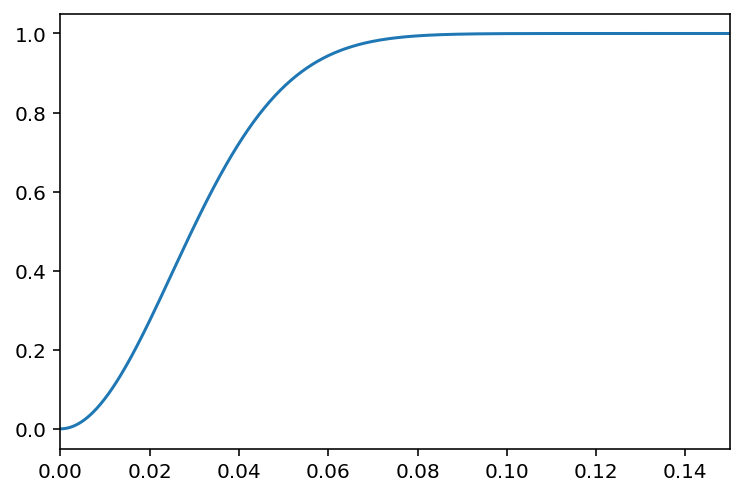

In [7]:
numpy2ri.activate()  # to call pcf on a numpy array
fig, ax = plt.subplots()
r = np.linspace(0, 0.3, 1000)
ax.plot(r, pcf(r))
ax.set_xlim(0, 0.15)

#### Simulation

Define the window where the points will be sampled from

In [8]:
# using spatstat.geom.boxx
numpy2ri.activate()
bound = np.array([0, 2])
window = spatstat.geom.boxx(bound, bound)

# using spatstat.geom.owin
bound = robjects.FloatVector([0, 2])
window = spatstat.geom.owin(xrange=bound, yrange=bound)

Generate the sample using `spatstat.core.simulate_dppm`

In [9]:
rsample = spatstat.core.simulate_dppm(my_dpp, W=window)
rsample

window,[RTYPES.VECSXP]
n,[RTYPES.INTSXP]
x,[RTYPES.REALSXP]
y,[RTYPES.REALSXP]
markformat,[RTYPES.STRSXP]


Convert spatstat sample to a numpy.array (as if the sample was generated or imported using Python)

In [10]:
sample = np.array([rsample.rx2("x"), rsample.rx2("y")])
sample.shape

(2, 411)

Display the sample

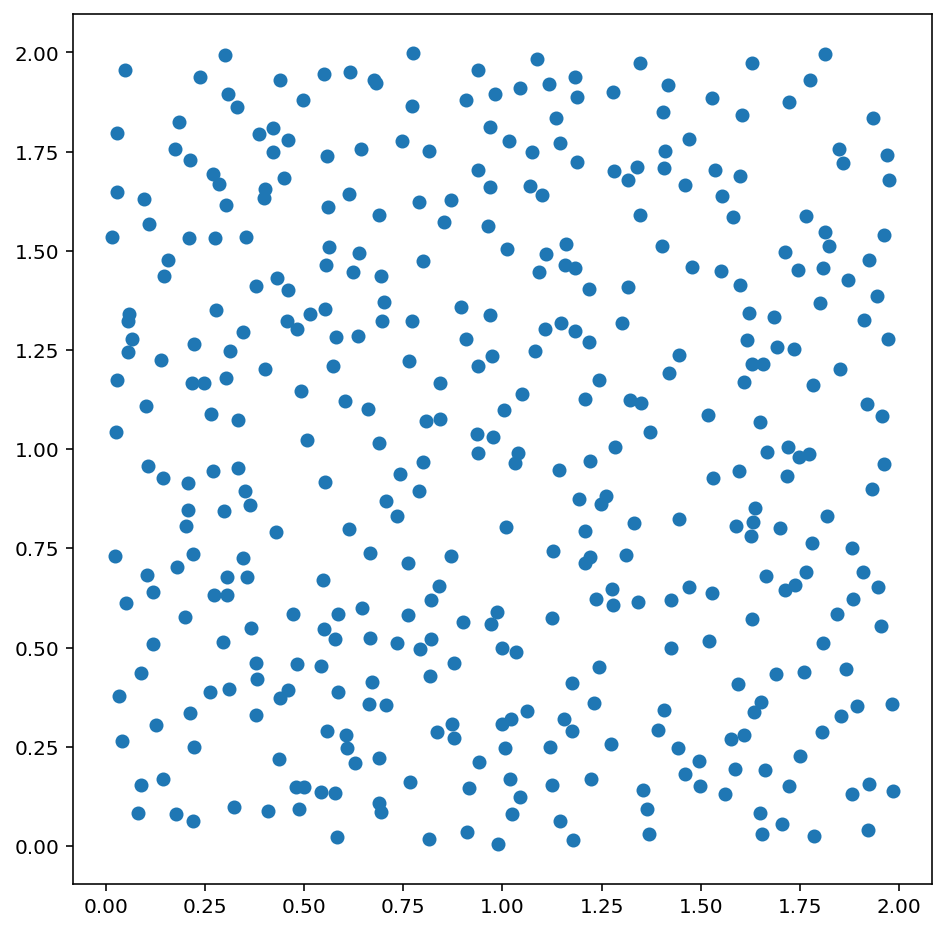

In [11]:
fig, ax = plt.subplots(figsize=(8, 8))
r = np.linspace(0, 0.3, 1000)
ax.scatter(*sample) # equivalent to scatter(sample[0], sample[1])
ax.set_aspect('equal', 'box')

#### Estimation

From a sample generated by spatstat

In [12]:
# If numpy2ri.activate() the output of spatstat.core.pcf is automatically converted to a numpy array 
# Otherwise it is an R DataFrame that we can convert to a pandas DataFrame
numpy2ri.deactivate()
pcf_r = spatstat.core.pcf_ppp(rsample)
pcf_df = to_pandas_data_frame(pcf_r)
pcf_df

,r,theo,trans,iso
1,0.000000,1.0,inf,inf
2,0.000977,1.0,0.255719,0.253961
3,0.001953,1.0,0.142367,0.141389
4,0.002930,1.0,0.104927,0.104200
5,0.003906,1.0,0.094276,0.093589
...,...,...,...,...
509,0.496094,1.0,0.950931,0.958100
510,0.497070,1.0,0.953443,0.959895
511,0.498047,1.0,0.956312,0.961881
512,0.499023,1.0,0.959220,0.963911


(0.0, 0.15)

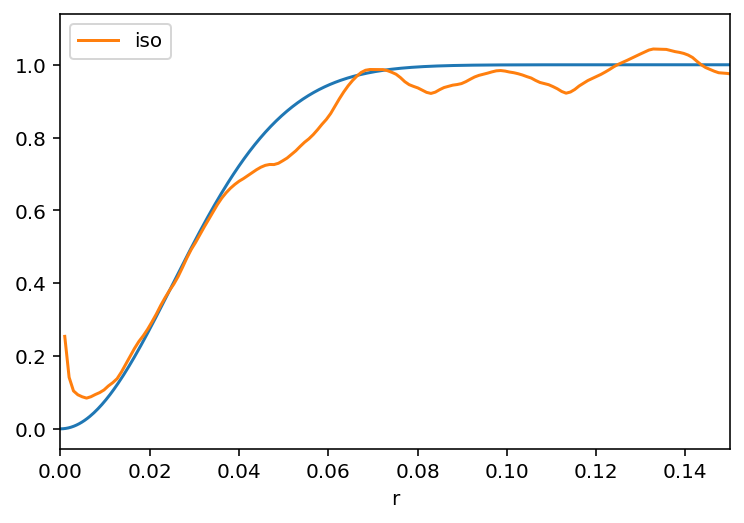

In [13]:
fig, ax = plt.subplots()
r = np.linspace(0, 0.3, 1000)
numpy2ri.activate()
ax.plot(r, pcf(r))
pcf_df.plot("r", "iso", ax=ax)
ax.set_xlim(0, 0.15)

From a sample stored in a numpy array

In [14]:
numpy2ri.activate()
# Each row of sample is associated to a coordinate, i.e., samples are stored columnwise
X = spatstat.geom.ppp(*sample, window=window)
numpy2ri.deactivate()
pcf_r = spatstat.core.pcf_ppp(X)
pcf_df = to_pandas_data_frame(pcf_r)
pcf_df

,r,theo,trans,iso
1,0.000000,1.0,inf,inf
2,0.000977,1.0,0.255719,0.253961
3,0.001953,1.0,0.142367,0.141389
4,0.002930,1.0,0.104927,0.104200
5,0.003906,1.0,0.094276,0.093589
...,...,...,...,...
509,0.496094,1.0,0.950931,0.958100
510,0.497070,1.0,0.953443,0.959895
511,0.498047,1.0,0.956312,0.961881
512,0.499023,1.0,0.959220,0.963911


(0.0, 0.15)

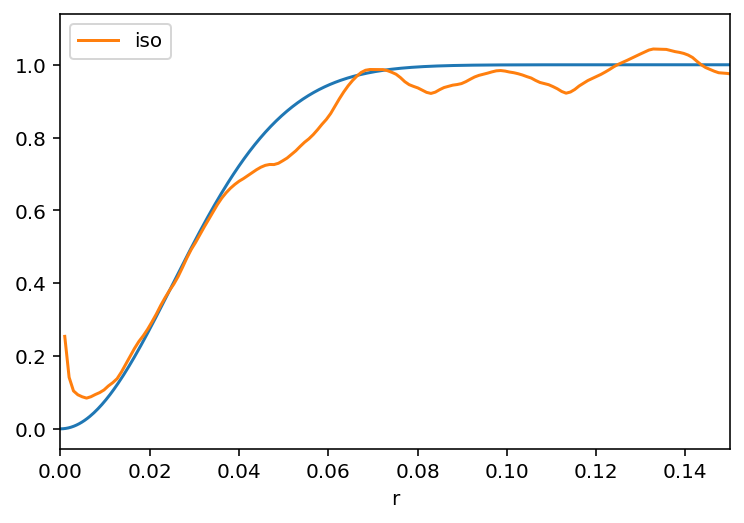

In [15]:
fig, ax = plt.subplots()
r = np.linspace(0, 0.3, 1000)
numpy2ri.activate()
ax.plot(r, pcf(r))
pcf_df.plot("r", "iso", ax=ax)
ax.set_xlim(0, 0.15)

#### Kernel parameter estimation for a sample

In [16]:
def convert_to_dict(x):
    return dict(zip(x.names, x))

Recall the parameters of the original DPP

In [17]:
params = convert_to_dict(my_dpp.rx2("fixedpar"))
params

{'lambda': array([100], dtype=int32),
 'alpha': array([0.05]),
 'd': array([2], dtype=int32)}

Fit a DPP from a sample

In [18]:
dpp_family = spatstat.core.dppGauss
formula = robjects.Formula("X ~ 1")
formula.environment["X"] = rsample

my_dpp_fitted = spatstat.core.dppm(formula=formula, family=dpp_family).rx2("fitted")
fitted_params = convert_to_dict(my_dpp_fitted.rx2("fixedpar"))
fitted_params

{'alpha': array([0.05565883]), 'lambda': array([102.75]), 'd': array([2.])}

In [19]:
pcf_fitted_dpp = spatstat.core.pcfmodel(my_dpp_fitted)

Let's have a look at the correlation function.

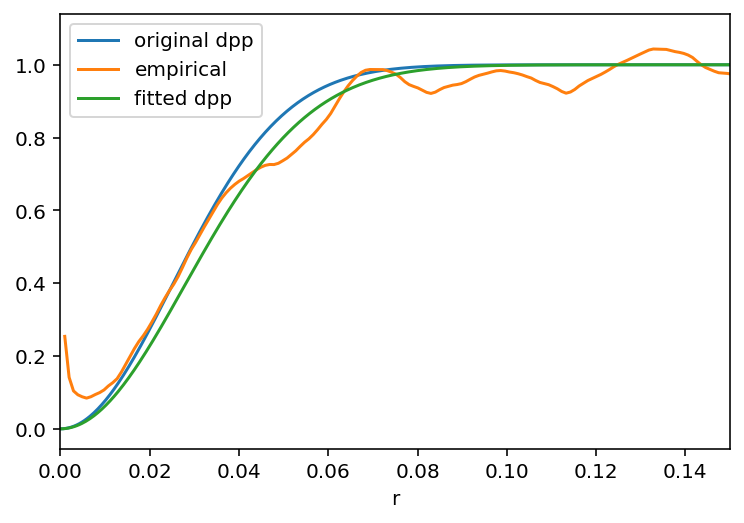

In [20]:
fig, ax = plt.subplots()

r = np.linspace(0, 0.3, 1000)
numpy2ri.activate()
ax.plot(r, pcf(r), label="original dpp")
pcf_df.plot("r", "iso", ax=ax, label="empirical")
ax.plot(r, pcf_fitted_dpp(r), label="fitted dpp")

ax.set_xlim(0, 0.15)
plt.legend()